# CONFLUENCE Tutorial: Elevation-Based HRU Discretization

This notebook demonstrates elevation-based HRU discretization, building on the distributed domain from Tutorial 2. We'll:

1. Use the existing GRUs from Tutorial 2
2. Apply elevation-based discretization
3. Run the model
4. Compare results with lumped and GRU-based approaches

**Prerequisites**: Tutorial 2 must be completed successfully.

## 1. Setup

In [1]:
# Import required libraries
import sys
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import CONFLUENCE
from CONFLUENCE import CONFLUENCE

plt.style.use('default')
%matplotlib inline

## 2. Load Configuration from Tutorial 2 and Modify for Elevation Discretization

In [2]:
# Load the distributed configuration from Tutorial 2
distributed_config_path = Path('./bow_distributed_config.yaml')

if not distributed_config_path.exists():
    raise FileNotFoundError("Tutorial 2 must be run first! Config file not found.")

with open(distributed_config_path, 'r') as f:
    config = yaml.safe_load(f)

# Modify for elevation discretization
config['DOMAIN_NAME'] = 'Bow_at_Banff_elevation'
config['EXPERIMENT_ID'] = 'elevation_bands'
config['DOMAIN_DISCRETIZATION'] = 'elevation'  # Key change!
config['ELEVATION_BAND_SIZE'] = 200  # 200m bands
config['MIN_HRU_SIZE'] = 4  # 4 km² minimum

# Save modified configuration
elevation_config_path = Path('./bow_elevation_config.yaml')
with open(elevation_config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("Configuration updated for elevation discretization:")
print(f"  Discretization: {config['DOMAIN_DISCRETIZATION']}")
print(f"  Elevation bands: {config['ELEVATION_BAND_SIZE']}m")
print(f"  Min HRU size: {config['MIN_HRU_SIZE']} km²")

Configuration updated for elevation discretization:
  Discretization: elevation
  Elevation bands: 200m
  Min HRU size: 4 km²


## 3. Initialize CONFLUENCE

In [3]:
# Initialize CONFLUENCE
confluence = CONFLUENCE(elevation_config_path)
print(f"Initialized CONFLUENCE for: {confluence.config['DOMAIN_NAME']}")

2025-05-10 17:30:39,262 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


Initialized CONFLUENCE for: Bow_at_Banff_elevation


## 4. Copy Domain from Tutorial 2

We'll copy the GRU shapefiles from Tutorial 2 to avoid re-running delineation.

In [10]:
import shutil
import os

# Source paths (from Tutorial 2)
source_domain = confluence.data_dir / 'domain_Bow_at_Banff_distributed'
target_domain = confluence.project_dir

# Create directories if needed
target_domain.mkdir(parents=True, exist_ok=True)

# Copy necessary directories
directories_to_copy = ['shapefiles', 'attributes']
for dir_name in directories_to_copy:
    source_dir = source_domain / dir_name
    target_dir = target_domain / dir_name
    
    if source_dir.exists():
        print(f"Copying {dir_name} from Tutorial 2...")
        shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
        
        # Replace _distributed with _elevation in all copied files
        print(f"Replacing '_distributed' with '_elevation' in {dir_name}...")
        for root, dirs, files in os.walk(target_dir):
            for file in files:
                old_path = os.path.join(root, file)
                
                # Replace in filename if needed
                if '_distributed' in file:
                    new_filename = file.replace('_distributed', '_elevation')
                    new_path = os.path.join(root, new_filename)
                    os.rename(old_path, new_path)
                    old_path = new_path  # Update path for content replacement
                
    else:
        print(f"Warning: {source_dir} not found. Run Tutorial 2 first.")

print("\nDomain files ready for elevation discretization")

Copying shapefiles from Tutorial 2...
Replacing '_distributed' with '_elevation' in shapefiles...
Copying attributes from Tutorial 2...
Replacing '_distributed' with '_elevation' in attributes...

Domain files ready for elevation discretization


## 5. Apply Elevation Discretization

This is the key step - creating HRUs based on elevation bands within each GRU.

In [11]:
# Check existing GRUs before discretization
basin_path = confluence.project_dir / 'shapefiles' / 'river_basins'
if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    if basin_files:
        gru_gdf = gpd.read_file(basin_files[0])
        print(f"Starting with {len(gru_gdf)} GRUs")

# Apply elevation discretization
print(f"\nApplying elevation discretization ({config['ELEVATION_BAND_SIZE']}m bands)...")
confluence.discretize_domain()

# Analyze results
hru_path = confluence.project_dir / 'shapefiles' / 'catchment'
if hru_path.exists():
    hru_files = list(hru_path.glob('*.shp'))
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        
        print(f"\nCreated {len(hru_gdf)} HRUs from {hru_gdf['GRU_ID'].nunique()} GRUs")
        print(f"Average: {len(hru_gdf)/hru_gdf['GRU_ID'].nunique():.1f} HRUs per GRU")
        
        # Show distribution
        hru_counts = hru_gdf.groupby('GRU_ID').size()
        print("\nHRUs per GRU:")
        for gru_id, count in hru_counts.items():
            print(f"  GRU {gru_id}: {count} HRUs")

2025-05-10 17:40:19,967 - confluence_general - INFO - Discretizing domain using method: elevation
2025-05-10 17:40:19,969 - confluence_general - INFO - Starting domain discretization using method: elevation
2025-05-10 17:40:19,970 - confluence_general - INFO - Step 1/2: Running discretization method


Starting with 49 GRUs

Applying elevation discretization (200m bands)...


2025-05-10 17:40:20,281 - confluence_general - INFO - Processing 49 GRUs using 32 cores
2025-05-10 17:40:21,078 - confluence_general - INFO - Processed 4/49 GRUs (8.2%)
2025-05-10 17:40:21,155 - confluence_general - INFO - Processed 8/49 GRUs (16.3%)
2025-05-10 17:40:21,220 - confluence_general - INFO - Processed 12/49 GRUs (24.5%)
2025-05-10 17:40:21,318 - confluence_general - INFO - Processed 16/49 GRUs (32.7%)
2025-05-10 17:40:21,327 - confluence_general - INFO - Processed 20/49 GRUs (40.8%)
2025-05-10 17:40:21,395 - confluence_general - INFO - Processed 24/49 GRUs (49.0%)
2025-05-10 17:40:21,405 - confluence_general - INFO - Processed 28/49 GRUs (57.1%)
2025-05-10 17:40:21,422 - confluence_general - INFO - Processed 32/49 GRUs (65.3%)
2025-05-10 17:40:21,454 - confluence_general - INFO - Processed 36/49 GRUs (73.5%)
2025-05-10 17:40:21,494 - confluence_general - INFO - Processed 40/49 GRUs (81.6%)
2025-05-10 17:40:21,515 - confluence_general - INFO - Processed 44/49 GRUs (89.8%)
20


Created 49 HRUs from 49 GRUs
Average: 1.0 HRUs per GRU

HRUs per GRU:
  GRU 8: 1 HRUs
  GRU 9: 1 HRUs
  GRU 10: 1 HRUs
  GRU 14: 1 HRUs
  GRU 15: 1 HRUs
  GRU 18: 1 HRUs
  GRU 24: 1 HRUs
  GRU 27: 1 HRUs
  GRU 29: 1 HRUs
  GRU 32: 1 HRUs
  GRU 33: 1 HRUs
  GRU 38: 1 HRUs
  GRU 39: 1 HRUs
  GRU 41: 1 HRUs
  GRU 43: 1 HRUs
  GRU 46: 1 HRUs
  GRU 48: 1 HRUs
  GRU 52: 1 HRUs
  GRU 53: 1 HRUs
  GRU 55: 1 HRUs
  GRU 56: 1 HRUs
  GRU 58: 1 HRUs
  GRU 60: 1 HRUs
  GRU 62: 1 HRUs
  GRU 67: 1 HRUs
  GRU 72: 1 HRUs
  GRU 74: 1 HRUs
  GRU 82: 1 HRUs
  GRU 83: 1 HRUs
  GRU 86: 1 HRUs
  GRU 87: 1 HRUs
  GRU 88: 1 HRUs
  GRU 92: 1 HRUs
  GRU 94: 1 HRUs
  GRU 97: 1 HRUs
  GRU 102: 1 HRUs
  GRU 110: 1 HRUs
  GRU 111: 1 HRUs
  GRU 113: 1 HRUs
  GRU 114: 1 HRUs
  GRU 115: 1 HRUs
  GRU 116: 1 HRUs
  GRU 117: 1 HRUs
  GRU 118: 1 HRUs
  GRU 119: 1 HRUs
  GRU 120: 1 HRUs
  GRU 121: 1 HRUs
  GRU 122: 1 HRUs
  GRU 123: 1 HRUs


## 6. Visualize the Elevation Discretization

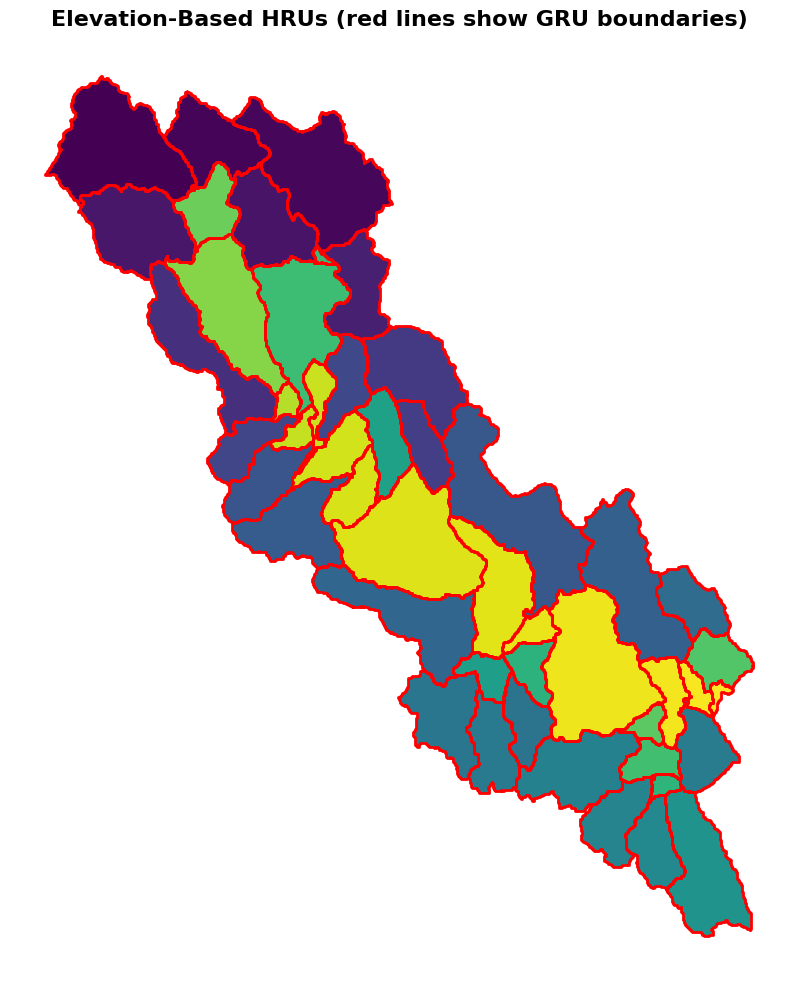

In [12]:
# Visualize the HRUs
if 'hru_gdf' in locals() and 'gru_gdf' in locals():
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot HRUs colored by elevation (if available)
    if 'mean_elev' in hru_gdf.columns:
        hru_gdf.plot(ax=ax, column='mean_elev', cmap='terrain', 
                    edgecolor='gray', linewidth=0.5, legend=True,
                    legend_kwds={'label': 'Elevation (m)'})
    else:
        hru_gdf.plot(ax=ax, column='HRU_ID', cmap='viridis', 
                    edgecolor='gray', linewidth=0.5)
    
    # Overlay GRU boundaries in red
    gru_gdf.boundary.plot(ax=ax, color='red', linewidth=2)
    
    ax.set_title('Elevation-Based HRUs (red lines show GRU boundaries)', 
                fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

## 7. Complete the Workflow

In [13]:
# Complete remaining workflow steps
print("Completing workflow with elevation-based HRUs...\n")

# Process observed data
print("Processing observed data...")
confluence.process_observed_data()

# Acquire forcings
print("Acquiring forcing data...")
confluence.acquire_forcings()

# Model-agnostic preprocessing
print("Running model-agnostic preprocessing...")
confluence.model_agnostic_pre_processing()

# Model-specific preprocessing
print("Preparing model input files...")
confluence.model_specific_pre_processing()

# Run the model
print("\nRunning SUMMA with elevation-based HRUs...")
confluence.run_models()

# Visualize results
print("Creating visualizations...")
confluence.visualise_model_output()

print("\n✓ Workflow complete!")

2025-05-10 17:43:41,464 - confluence_general - INFO - Processing observed data
2025-05-10 17:43:41,466 - confluence_general - INFO - Processing WSC streamflow data from HYDAT database
2025-05-10 17:43:41,471 - confluence_general - INFO - Querying data from year 2018 to 2025
2025-05-10 17:43:41,472 - confluence_general - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database
2025-05-10 17:43:41,473 - confluence_general - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3
2025-05-10 17:43:41,475 - confluence_general - INFO - Time period: 2018 to 2025
2025-05-10 17:43:41,518 - confluence_general - INFO - Found station 05BB001 in HYDAT database
2025-05-10 17:43:41,521 - confluence_general - INFO - Station name: BOW RIVER AT BANFF
2025-05-10 17:43:41,523 - confluence_general - INFO - Executing SQL query for daily flows...
2025-05-10 17:43:41,553 - confluence_general - INFO - Retrieved 72 monthly records from HYDAT
2025-05-10 17:43:41,635 -

Completing workflow with elevation-based HRUs...

Processing observed data...


2025-05-10 17:43:42,361 - confluence_general - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_elevation/observations/streamflow/preprocessed/Bow_at_Banff_elevation_streamflow_processed.csv
2025-05-10 17:43:42,363 - confluence_general - INFO - Total rows in processed data: 52561
2025-05-10 17:43:42,364 - confluence_general - INFO - Number of non-null values: 52561
2025-05-10 17:43:42,366 - confluence_general - INFO - Number of null values: 0
2025-05-10 17:43:42,373 - confluence_general - INFO - Successfully processed WSC data for station 05BB001
2025-05-10 17:43:42,375 - confluence_general - INFO - Observed data processing completed successfully


Acquiring forcing data...


2025-05-10 17:43:45,663 - confluence_general - INFO - datatool job submitted successfully.


KeyboardInterrupt: 

## 8. Compare All Three Approaches

Let's create a visualization comparing the three approaches we've covered.

In [ ]:
# Create comparison figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Directory paths for different approaches
lumped_dir = confluence.data_dir / 'domain_Bow_at_Banff_lumped'
distributed_dir = confluence.data_dir / 'domain_Bow_at_Banff_distributed'
elevation_dir = confluence.project_dir

# Plot lumped (if exists)
lumped_basin = lumped_dir / 'shapefiles' / 'river_basins'
if lumped_basin.exists():
    files = list(lumped_basin.glob('*.shp'))
    if files:
        gdf = gpd.read_file(files[0])
        gdf.plot(ax=axes[0], color='lightblue', edgecolor='navy', linewidth=2)
        axes[0].set_title('Lumped\n(1 Unit)', fontsize=14, fontweight='bold')

# Plot GRU-based (if exists)
dist_catchment = distributed_dir / 'shapefiles' / 'catchment'
if dist_catchment.exists():
    files = list(dist_catchment.glob('*.shp'))
    if files:
        gdf = gpd.read_file(files[0])
        gdf.plot(ax=axes[1], column='GRU_ID', cmap='Set3', 
                edgecolor='black', linewidth=1)
        axes[1].set_title(f'GRU-Based\n({len(gdf)} HRUs)', fontsize=14, fontweight='bold')

# Plot elevation-based
if 'hru_gdf' in locals():
    if 'mean_elev' in hru_gdf.columns:
        hru_gdf.plot(ax=axes[2], column='mean_elev', cmap='terrain', 
                    edgecolor='gray', linewidth=0.5)
    else:
        hru_gdf.plot(ax=axes[2], column='HRU_ID', cmap='viridis', 
                    edgecolor='gray', linewidth=0.5)
    axes[2].set_title(f'Elevation-Based\n({len(hru_gdf)} HRUs)', fontsize=14, fontweight='bold')

# Format all axes
for ax in axes:
    ax.axis('off')

plt.suptitle('Comparison of Domain Discretization Approaches', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Create Summary Table

In [ ]:
# Create summary statistics
summary_data = []

# Lumped stats
lumped_hru = lumped_dir / 'shapefiles' / 'catchment'
if lumped_hru.exists():
    files = list(lumped_hru.glob('*.shp'))
    if files:
        gdf = gpd.read_file(files[0])
        summary_data.append({
            'Approach': 'Lumped',
            'GRUs': 1,
            'HRUs': len(gdf),
            'HRUs per GRU': len(gdf),
            'Complexity': 'Low'
        })

# GRU-based stats
if dist_catchment.exists():
    files = list(dist_catchment.glob('*.shp'))
    if files:
        gdf = gpd.read_file(files[0])
        n_grus = gdf['GRU_ID'].nunique()
        summary_data.append({
            'Approach': 'GRU-Based',
            'GRUs': n_grus,
            'HRUs': len(gdf),
            'HRUs per GRU': len(gdf)/n_grus,
            'Complexity': 'Medium'
        })

# Elevation-based stats
if 'hru_gdf' in locals():
    n_grus = hru_gdf['GRU_ID'].nunique()
    summary_data.append({
        'Approach': 'Elevation-Based',
        'GRUs': n_grus,
        'HRUs': len(hru_gdf),
        'HRUs per GRU': len(hru_gdf)/n_grus,
        'Complexity': 'High'
    })

# Create and display table
if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df['HRUs per GRU'] = summary_df['HRUs per GRU'].round(1)
    
    print("=== Summary of Discretization Approaches ===")
    print(summary_df.to_string(index=False))
    
    # Create a visual table
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=summary_df.values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    
    plt.title('Domain Discretization Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.show()

## 10. Summary

### Key Takeaways

1. **Lumped**: Entire watershed as one unit - simplest but least detailed
2. **GRU-Based**: One HRU per sub-basin - balanced approach
3. **Elevation-Based**: Multiple HRUs per GRU based on elevation - most detailed

### When to Use Each Approach

- **Lumped**: Quick assessments, small watersheds, limited data
- **GRU-Based**: Standard distributed modeling, moderate complexity
- **Elevation-Based**: Mountainous regions, snow processes, climate gradients

### Trade-offs

- **Computational Cost**: Lumped < GRU-Based < Elevation-Based
- **Spatial Detail**: Lumped < GRU-Based < Elevation-Based
- **Parameter Requirements**: Lumped < GRU-Based < Elevation-Based
- **Data Requirements**: Lumped < GRU-Based < Elevation-Based

In [ ]:
# Final output locations
print("=== Elevation Discretization Complete ===\n")
print(f"Project: {confluence.config['DOMAIN_NAME']}")
print(f"HRU shapefile: {confluence.project_dir / 'shapefiles' / 'catchment'}")
print(f"Model results: {confluence.project_dir / 'simulations' / confluence.config['EXPERIMENT_ID']}")
print(f"Plots: {confluence.project_dir / 'plots' / 'results'}")